# DMLearn Basics: Mixture Models

The notebook ` provides a brief overview of DMLearn's base distributions and combinators. There, we introduced the **base distributions** for continuous and discrete data, along with the **combinator distributions** used to warp base distributions. 

In this notebook, we introduce the mixture model and several variations of mixture models available in DMLearn. We will discuss:

- Mixture Model
- `optimize`
- `best_of`
- Hierarchical Mixture Model
- Joint Mixture Model
- Heterogeneous Mixture Model

In [2]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

sys.path.append('../../')

%matplotlib notebook

os.environ['NUMBA_DISABLE_JIT'] =  '1'
from dml.stats import *
from dml.utils.estimation import optimize, iterate, partition_data, best_of, empirical_kl_divergence
import dml.utils.optsutil as ops

## Mixture Models

Mixture models are used to represent a finite collection of distinct behaviors. They are a core tool in unsupervised machine learning, as the identity of the underlying mixture component is not directly observed, but can often be inferred from the data.

Given a finite set of likelihood functions, $\ell_1(x; \theta_1), \dots, \ell_K(x; \theta_K)$, and weights $w_1, \dots, w_K$ such that $w_k \geq 0$ and $\sum_{k=1}^{K} w_k = 1$, the mixture distribution has likelihood:

$$
\ell(x; \boldsymbol{\theta}) = \sum_{k=1}^{K} w_k\, \ell_k(x; \theta_k)
$$

---

**Data Example**

Consider a mixture of two Gaussian components:
- $\ell_1(x) \sim \mathcal{N}(5, 1)$
- $\ell_2(x) \sim \mathcal{N}(15, 1)$

with mixture weights $w_1 = 0.3$ and $w_2 = 0.7$. The weights represent the probability that $X$ is drawn from each component: $P(X \text{ is drawn from } \ell_k) = w_k$.

The generative process for this mixture model is:

1. Draw $U_i \sim \mathrm{Uniform}(0, 1)$
2. If $U_i \leq 0.3$, set $Z_i = 1$; else, set $Z_i = 2$
3. Draw $X_i$:
   - If $Z_i = 1$, $X_i \sim \mathcal{N}(5, 1)$
   - If $Z_i = 2$, $X_i \sim \mathcal{N}(15, 1)$
4. Repeat steps 1–3 for $N$ samples

---

This example illustrates how mixture models can represent data generated from multiple underlying distributions, with the mixture weights controlling the proportion of data from each component.

In [3]:
p = 0.3
N = 5000
rng = np.random.RandomState(1)

data = []
z1 = []
z2 = []
for i in range(N):
    if rng.rand() <= p:
        z1.append(i)
        data.append(rng.normal(loc=5,scale=1))
    else:
        z2.append(i)
        data.append(rng.normal(loc=15, scale=1))

        
fig,ax = plt.subplots()
ax.hist([data[xx] for xx in z1], bins=range(0,20), label='Cluster 1', weights=np.ones(len(z1))/N)
ax.hist([data[xx] for xx in z2], bins=range(0, 20), label='Cluster 2', weights=np.ones(len(z2))/N)

ax.legend();
fig.show()

<IPython.core.display.Javascript object>

DMLearn supports mixtures through the `MixtureDistribution` and `MixtureEstimator` classes.

- The `MixtureDistribution` class takes two arguments:
    - `components`: A list of the component distributions (in the above example, $\ell_1$ and $\ell_2$ are `GaussianDistribution` objects)
    - `w`: A list or numpy array containing the probability of drawing the corresponding component

- The `MixtureEstimator` takes a list of estimators for each mixture component.

---

If `components` is $[\ell_1, \ldots, \ell_K]$, then:

- The **complete data likelihood** for observed data $\mathbf{x} = (x_1, \dots, x_N)$ and unobserved assignment variables $\mathbf{z} = (z_1, \dots, z_N)$ is:
  $$
  \ell(\mathbf{x}, \mathbf{z}) = \prod_{i=1}^{N} P(z_i) \cdot \ell_{z_i}(x_i) = \prod_{i=1}^{N} w_{z_i} \cdot \ell_{z_i}(x_i)
  $$

- The **observed data likelihood** (marginalizing out each latent state $z_i$) is:
  $$
  \ell(\mathbf{x}) = \prod_{i=1}^{N} \sum_{z_i=1}^{K} P(z_i) \cdot \ell_{z_i}(x_i) = \prod_{i=1}^{N} \sum_{k=1}^{K} w_k \cdot \ell_k(x_i)
  $$

---

To estimate the Gaussian mixture in the example above, we must specify a `MixtureEstimator`. The `MixtureEstimator` object requires as argument a list of estimators for the components. In this example, the `estimators` argument is a list of two `GaussianEstimator` objects. The length of this list determines the number of components to be estimated.

**Note:** `optimize` performs the EM (Expectation-Maximization) algorithm for estimating the weights and parameters of the mixture distribution.

In [4]:
rng = np.random.RandomState(2)
est0 = GaussianEstimator()
est = MixtureEstimator(estimators=[est0]*2)
emodel = optimize(data, est, init_p=0.10, rng=rng, max_its=200, print_iter=10)

Iteration 10: ln[p_mat(Data|Model)]=-1.141903e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=3.193953e+02
Iteration 15: ln[p_mat(Data|Model)]=-1.021319e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=0.000000e+00


In [5]:
fig,ax = plt.subplots()
ax.hist([data[xx] for xx in z1], bins=range(0,20), label='Cluster 1', weights=np.ones(len(z1))/N)
ax.hist([data[xx] for xx in z2], bins=range(0,20), label='Cluster 2', weights=np.ones(len(z2))/N)
ax.legend();

xvals = np.arange(np.min(data), np.max(data)+1)
omodel = MixtureDistribution(components=[GaussianDistribution(5,1), GaussianDistribution(15,1)],w=np.array([0.3, 0.7]))
ax.plot(xvals, [omodel.density(u) for u in xvals], '--k', label='Real Model')
ax.plot(xvals, [emodel.density(u) for u in xvals], 'r', label='Estimated Model')
ax.set_ylabel('Likelihood');
fig.show()

print(emodel)

<IPython.core.display.Javascript object>

MixtureDistribution([GaussianDistribution(15.015723167732396, 1.039967147482514, name=None, keys=None),GaussianDistribution(4.968396585863806, 0.9919700720272431, name=None, keys=None)], [0.6995999959134943, 0.3004000040865057], name=None, keys=(None, None))


### Mixture of Multivariate Gaussians

We've seen a simple example of a mixture of two independent Gaussians. Now, let's look at a mixture of three 2-dimensional multivariate Gaussians. Recall that the `MultivariateGaussianDistribution` takes arguments for the mean (as a 1-D list) and the covariance (as a 2-D list).

We define `dist` as a three-component `MixtureDistribution`, where each component is a 2-D `MultivariateGaussianDistribution` and the mixture weights are `[0.4, 0.4, 0.2]`.


In [9]:
rng = np.random.RandomState(1)

d1 = MultivariateGaussianDistribution([-8.0, -8.0], [[2.0, 1.0], [1.0, 2.0]])
d2 = MultivariateGaussianDistribution([ 0.0,  0.0], [[2.0, -1.0], [-1.0, 2.0]])
d3 = MultivariateGaussianDistribution([ 5.0,  1.0], [[2.0, 1.0], [1.0, 2.0]])

dist = MixtureDistribution([d1, d2, d3], [0.4, 0.4, 0.2])

sampler = dist.sampler(seed=1)
data = sampler.sample(size=2000)

Take a look at the data plotted in blue and means of each multivariate Gaussian plotted in red. 

In [10]:
fig,ax = plt.subplots()

mus = np.asarray([u.mu for u in dist.components])
data2 = np.asarray(data)

ax.scatter(data2[:,0], data2[:,1], s=0.7)
mus = np.asarray([comp.mu for comp in dist.components])
ax.scatter(mus[:,0], mus[:,1], c='r', s=30);

fig.show()

<IPython.core.display.Javascript object>

As before we need to specfiy a `MixtureEstimator` for estimation. The following line is the estimator for a three component mixture of bivariate normal distributions.

In [11]:
est = MixtureEstimator([MultivariateGaussianEstimator(dim=2)]*3)

**Estimation with `best_of`**

Often, we use validation data to perform model selection. The function `partition_data` randomly splits the observed data into a training and validation set. The argument `[0.8, 0.2]` specifies an 80% training and 20% validation (test) split.

The following line performs five random initializations of the EM algorithm, using 10% of the data for initialization. The algorithm iterates until either 100 iterations are reached or the difference in log-likelihood drops below $1.0 \times 10^{-6}$. The model that best fits the validation set (`valid_data`) is returned as `dist_est`.

In [12]:
rng = np.random.RandomState(1)

train_data, valid_data = partition_data(data, [0.8, 0.2], rng)
_, dist_est = best_of(train_data, valid_data, est, 5, 100, 0.1, 1.0e-6, rng, print_iter=200)


Trial 1. VLL=-1738.351061
Trial 2. VLL=-1738.351281
Trial 3. VLL=-1738.347886
Trial 4. VLL=-1738.348138
Trial 5. VLL=-1738.351154


Below is a side-by-side scatter plot of the data. The left-hand plot shows the true data with the true mean locations marked in red. The right-hand plot shows the same data, but with the estimated means plotted in yellow.

As we can see, the estimated means closely match the true means.

In [13]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

mus = np.asarray([u.mu for u in dist_est.components])
data2 = np.asarray(data)

muhats = np.asarray([comp.mu for comp in dist_est.components])


ax1.scatter(data2[:,0], data2[:,1], s=0.7)
ax1.scatter(mus[:,0], mus[:,1], c='r', s=30);
ax2.scatter(data2[:,0], data2[:,1], s=0.7)
ax2.scatter(muhats[:,0], muhats[:,1], c='y', s=20)

fig.show()

<IPython.core.display.Javascript object>

The above example uses DMLearn's vectorized estimation. Alternatively, we could use the (much much slower) entry level estimation. We'll take this opportunity to monitor some of EM's visiable parts. 

In [14]:
rng = np.random.RandomState(1)
model = initialize(train_data, est, rng, 0.1)

estimated_means = [[u.mu] for u in model.components]

vll = sum([model.log_density(u) for u in valid_data])
tll = sum([model.log_density(u) for u in train_data])

ll_history = [[vll, tll]]

print('Initialization: LL(train) = %f, LL(test) = %f'%(tll,vll))

for i in range(100):
    model = estimate(train_data, est, model)
    
    for j,u in enumerate(model.components):
        estimated_means[j].append(u.mu)
    
    vll = sum([model.log_density(u) for u in valid_data])
    tll = sum([model.log_density(u) for u in train_data])
    
    ll_history.append([vll, tll])
    if i % 10 == 0:
        print('Iteration %03d: LL(train) = %f, LL(test) = %f'%(i+1,tll,vll))

Initialization: LL(train) = -8350.158591, LL(test) = -2065.150667
Iteration 001: LL(train) = -8323.979157, LL(test) = -2065.443006
Iteration 011: LL(train) = -7364.581971, LL(test) = -1806.562738
Iteration 021: LL(train) = -7038.233500, LL(test) = -1738.423435
Iteration 031: LL(train) = -7035.970387, LL(test) = -1738.408801
Iteration 041: LL(train) = -7035.968210, LL(test) = -1738.357137
Iteration 051: LL(train) = -7035.968175, LL(test) = -1738.350556
Iteration 061: LL(train) = -7035.968174, LL(test) = -1738.349724
Iteration 071: LL(train) = -7035.968174, LL(test) = -1738.349619
Iteration 081: LL(train) = -7035.968174, LL(test) = -1738.349606
Iteration 091: LL(train) = -7035.968174, LL(test) = -1738.349604


The most obvious statistic to diagnose convergence is the validation and training average log-densities. These were captured by the variable `ll_history`.

In [15]:
ll_history = np.asarray(ll_history)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(ll_history[:,0]/len(valid_data), label='Validation E[LL]')
ax.plot(ll_history[:,1]/len(train_data), label='Training E[LL]')
ax.legend()
ax.grid();
fig.show()

<IPython.core.display.Javascript object>

Another informative (and cool!) thing to observe are the trajectories of the components.

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
fvals = np.zeros((3,2))
tvals = np.zeros((3,2))

for j,comp_history in enumerate(estimated_means):
    
    mu_history = np.asarray(comp_history)
    ax.plot(mu_history[:,0], mu_history[:,1], 'C%do--'%(j), label='Component %d'%(j+1))
    fvals[j,:] = [mu_history[0,0], mu_history[0,1]]
    
    # True distribution values
    tvals[j,:] = dist.components[j].mu
    
ax.scatter(fvals[:,0], fvals[:,1], c='r', s=100, label='Initialization')
ax.scatter(tvals[:,0], tvals[:,1], c='m', s=100, label='True Means')

ax.legend();
fig.show()

<IPython.core.display.Javascript object>

The above should give some intuition on the convergence and behavior of the EM algorithm. We will generally rely on `best_of` and `optimize` to fit models in DMLearn. `optimize` will perform a vectorized initialization and fit of a given model via the EM algorithm. When we are concerend with sensitivity of the EM algorithm's convergence with respect to initial conditions, `best_of` can be used.

### Composite Mixtures

Composite mixtures are powerful models for heterogeneous, *conditionally independent* feature vectors. Let's define the composite mixture and illustrate its use in DMLearn with an example.

#### Composite Mixture: Definition

Let $\boldsymbol{x} = \left(x_1, x_2, \dots, x_m \right)$ be an $m$-dimensional joint observation. The composite mixture model assumes that each feature $x_j$ is conditionally independent given a latent state $z$:

$$
\ell(x_1, x_2, \dots, x_m \mid z) = \prod_{j=1}^{m} \ell_j(x_j|z).
$$

This allows us to write the likelihood of an $m$-dimensional composite mixture model with $K$ states as

$$
\ell(x_1, x_2, \dots, x_m) = \sum_{z=1}^{K} \ell(x_1, x_2, \dots, x_m \mid z) P(z) = \sum_{k=1}^{K} \prod_{j=1}^{m} \ell_j(x_j|k) w_k
$$

where $w_k = P(z=k)$. The generative process is given by:

1. Sample a latent label $Z_i \sim$ $\text{IntegerCategorical}\left(w_1, w_2, \dots, w_K\right)$
2. For each $j = 1, 2, \dots, m$, sample $x_{ij} \mid z_i \sim P(x_j | z_i)$
3. Assign $\boldsymbol{x}_i = \left(x_{i1}, x_{i2}, \dots, x_{im}\right)$
4. Repeat steps 1–3 for $N$ samples



#### Composite Mixture: Data Generation

Assume we jointly observe a 4-dimensional data tuple:

$$
\boldsymbol{x} = (x_1, x_2, x_3, x_4) = (\text{real number},\ \text{maybe missing count},\ \text{sequence of strings},\ \text{set of values})
$$

An appropriate model for $\boldsymbol{x}$ is a `CompositeDistribution` with each component defined as follows:

1. **$x_1$:** A `MixtureDistribution` of two 1-D `GaussianDistribution`s.
2. **$x_2$:** An integer type that may be missing, modeled by an `OptionalDistribution` with a `GeometricDistribution` base (probability of missing $p = 0.1$).
3. **$x_3$:** A sequence of letters ('a', 'b'), modeled by a `MarkovChainDistribution` with a `PoissonDistribution` for the sequence length.
4. **$x_4$:** A set of values from $\{\text{'a'}, \text{'b'}, \text{'c'}, \text{'d'}\}$, modeled by a `BernoulliSetDistribution`.

In the example below, we define three `CompositeDistribution`s (`d1`, `d2`, `d3`), each with the same structure but different parameters for the first component (`MixtureDistribution`). We then create a `MixtureDistribution` over these three composite distributions with weights `[0.4, 0.3, 0.3]`.

This specifies a 3-component mixture over 4-dimensional composite distributions.


In [17]:
rng = np.random.RandomState(3)

d10 = MixtureDistribution([GaussianDistribution(-10.0, 1.0), GaussianDistribution(0.0, 1.0)], [0.5, 0.5])
d11 = OptionalDistribution(GeometricDistribution(0.1), p=0.1)
d12 = MarkovChainDistribution({'a' : 0.5, 'b' : 0.5}, {'a' : { 'a' : 0.2, 'b' : 0.8}, 'b' : { 'a' : 0.8, 'b' : 0.2}}, len_dist=PoissonDistribution(8.0))
d13 = BernoulliSetDistribution({'a' : 0.1, 'b': 0.3, 'c': 0.7, 'd':0.9})

# Mixture Component 1
d1  = CompositeDistribution([d10, d11, d12, d13])

d20 = MixtureDistribution([GaussianDistribution(10.0, 1.0), GaussianDistribution(5.0, 1.0)], [0.5, 0.5])
d21 = OptionalDistribution(GeometricDistribution(0.2), p=0.2)
d22 = MarkovChainDistribution({'a': 0.5, 'b': 0.5}, {'a': {'a': 0.8, 'b': 0.2}, 'b': {'a': 0.2, 'b': 0.8}}, len_dist=PoissonDistribution(8.0))
d23 = BernoulliSetDistribution({'a': 0.9, 'b': 0.8, 'c': 0.1, 'd': 0.1})

# Mixture Component 2
d2  = CompositeDistribution([d20, d21, d22, d23])

d30 = MixtureDistribution([GaussianDistribution(0.0, 1.0), GaussianDistribution(5.0, 1.0)], [0.5, 0.5])
d31 = OptionalDistribution(GeometricDistribution(0.9), p=0.01)
d32 = MarkovChainDistribution({'a': 0.8, 'b': 0.2}, {'a': {'a': 0.5, 'b': 0.5}, 'b': {'a': 0.2, 'b': 0.8}}, len_dist=PoissonDistribution(8.0))
d33 = BernoulliSetDistribution({'a': 0.5, 'b': 0.5, 'c': 0.5, 'd': 0.8})

# Mixture Component 3
d3  = CompositeDistribution([d30, d31, d32, d33])

# Mixture Model
dist = MixtureDistribution([d1, d2, d3], [0.4, 0.3, 0.3])

# Generate Data
sampler = dist.sampler(seed=1)
data = sampler.sample(size=1000)

# train / validation split for fitting
train_data, valid_data = partition_data(data, [0.8, 0.2], rng)

Here are some samples from out distribution. 

In [18]:
print('\n'.join(['Sample %d: '%(i) + str(data[i]) for i in range(15)]))

Sample 0: (0.6686303329964771, 2, ['a', 'b', 'a', 'b', 'b', 'a'], ['c', 'd'])
Sample 1: (10.350647916171429, 3, ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b'], ['a', 'b'])
Sample 2: (0.739563168142132, 1, ['a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'a'], ['b', 'c'])
Sample 3: (-0.2714997605268183, 5, ['a', 'b', 'b', 'a', 'b', 'a', 'b', 'b', 'a', 'a'], ['a', 'c', 'd'])
Sample 4: (9.99793581013596, 2, ['a', 'a', 'a', 'a', 'a', 'a', 'b'], ['a', 'b'])
Sample 5: (2.4818289083013707, 17, ['a', 'b', 'a', 'b', 'a', 'b', 'a', 'b', 'a', 'a'], ['c'])
Sample 6: (3.5814342690219645, 2, ['a', 'a', 'b', 'a', 'b', 'b', 'b', 'b', 'b', 'b'], ['c', 'd'])
Sample 7: (-10.458094237090492, 6, ['a', 'b', 'a', 'b', 'a', 'b', 'a', 'b'], ['c', 'd'])
Sample 8: (2.777018107143461, 16, ['a', 'a', 'a', 'a', 'a', 'a', 'b', 'b'], ['a', 'b'])
Sample 9: (5.056518661993016, 1, ['a', 'a', 'a', 'a'], ['a', 'b', 'd'])
Sample 10: (0.3237816486571098, 1, ['a', 'a', 'a', 'b', 'b', 'a', 'b', 'b'], ['a', 'c', 'd'])
Sample 11: (

#### Composite Mixture: Estimation

To estimate the parameters of a composite mixture model, you typically use either `optimize` (which checks for convergence using log-likelihood) or `iterate` (which simply runs for a fixed number of iterations without checking for convergence). If you only want a single estimate of the model (i.e., no multiple random restarts), `optimize` is usually sufficient.

To fit a composite mixture, you must specify an estimator for each component of the composite distribution. For example, if your composite distribution has four components, you need to provide four corresponding estimators to a `CompositeEstimator`. Then, to estimate a mixture of such composite distributions, you create a `MixtureEstimator` whose components are copies of your `CompositeEstimator`.

Example:

- `e0` estimates the first component (a mixture of two Gaussians).
- `e1` estimates the second component (an optional geometric distribution).
- `e2` estimates the third component (a Markov chain with Poisson length).
- `e3` estimates the fourth component (a Bernoulli set).

The `CompositeEstimator` groups these together, and the `MixtureEstimator` fits a mixture of three such composite distributions.

You can also use `best_of` for multiple random restarts and model selection, but for many use cases, a single call to `optimize` is sufficient.

In [19]:
rng = np.random.RandomState(1)

e0 = MixtureEstimator([GaussianEstimator()] * 2)
e1 = OptionalEstimator(GeometricEstimator(), est_prob=True)
e2 = MarkovChainEstimator(len_estimator=PoissonEstimator())
e3 = BernoulliSetEstimator()
comp_est = CompositeEstimator((e0, e1, e2, e3))
est = MixtureEstimator([comp_est] * 3)

#_, dist_est = best_of(train_data, valid_data, est, 5, 100, 0.1, 1.0e-6, rng, print_iter=20)

dist_est = optimize(data, est, max_its=500, rng=rng, print_iter=50)

Iteration 50: ln[p_mat(Data|Model)]=-1.424899e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=8.711540e-07
Iteration 100: ln[p_mat(Data|Model)]=-1.424899e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=1.210279e-06
Iteration 150: ln[p_mat(Data|Model)]=-1.424899e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=1.742623e-06
Iteration 200: ln[p_mat(Data|Model)]=-1.424899e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=2.633247e-06
Iteration 250: ln[p_mat(Data|Model)]=-1.424899e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=4.261201e-06
Iteration 300: ln[p_mat(Data|Model)]=-1.424899e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=7.642584e-06
Iteration 350: ln[p_mat(Data|Model)]=-1.424899e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=1.618195e-05
Iteration 400: ln[p_mat(Data|Model)]=-1.424899e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=4.617972e-05
Iteration 450: ln[p_mat(Data|Model)]=-1.424899e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel

Below we print out all three components for the estimates of the `MixtureDistribution`, for the first and fourth components of the `CompositeDistribution`. 

In [20]:
print('Composite Component 1: ')
for u in dist_est.components:
    print('Mix Comp: ' + str(u.dists[0]))

print('\nComposite Component 4:')
for u in dist_est.components:
    print('Mix Comp: ' + str(u.dists[-1]))

Composite Component 1: 
Mix Comp: MixtureDistribution([GaussianDistribution(-9.931034208063808, 0.8113571689611234, name=None, keys=None),GaussianDistribution(0.06370103493192618, 1.0480383579836523, name=None, keys=None)], [0.4821940090169043, 0.5178059909830957], name=None, keys=(None, None))
Mix Comp: MixtureDistribution([GaussianDistribution(7.89224989326414, 6.943578940902654, name=None, keys=None),GaussianDistribution(6.544056706811889, 6.359368270405, name=None, keys=None)], [0.657837545509796, 0.34216245449020394], name=None, keys=(None, None))
Mix Comp: MixtureDistribution([GaussianDistribution(2.6358715339138024, 7.472276334084824, name=None, keys=None),GaussianDistribution(2.444952661384224, 7.423516499984446, name=None, keys=None)], [0.49378911125510627, 0.5062108887448937], name=None, keys=(None, None))

Composite Component 4:
Mix Comp: BernoulliSetDistribution(dict([(np.str_('a'), np.float64(0.0961739723259043)), (np.str_('b'), np.float64(0.31264133874622835)), (np.str_('

### Mixture Model - Imputation

In the example above, many samples are missing the second component of the composite (the geometric part). To impute these missing values, we use the posterior probability over the hidden state, $P(Z = k \mid \text{observed features})$, to compute the conditional probability over the missing values:

$$
P(\text{unobserved features} \mid \text{observed features}) = \sum_{k = 1}^K P(\text{unobserved features} \mid Z = k) \, P(Z = k \mid \text{observed features})
$$

This approach allows us to combine the predictions from each mixture component, weighted by their posterior probabilities given the observed data.

Depending on the application (and the structure of the variable), you may choose to sample from this conditional distribution or compute its expected value


In [21]:
point = list(filter(lambda u: u[1] is None, data))[0]
posterior = dist_est.posterior(point)
print(str(point))
print(str(posterior))

(4.225630964827229, None, ['a', 'a', 'a', 'a', 'a', 'b', 'b'], ['a', 'b', 'd'])
[1.80724914e-07 9.53923462e-01 4.60763570e-02]


Since distributions in question are geometric with parameters $p_k$ for $k = 1, \ldots, K$, the conditional distribution has an expected value of

$$ E[P(\text{unobserved features} | \text{observed features})] = \sum_{k = 1}^{K} P(Z = k | \text{observed data}) \frac{1}{p_{k}} $$

We can either sample this distribution to compute its expected value (Monte Carlo approximation) or compute it analytically.

In [19]:
missing_conditional = MixtureDistribution([u.dists[1].dist for u in dist_est.components], posterior)
est_mean = np.dot(missing_conditional.w, [1/u.p for u in missing_conditional.components])
print(est_mean)

4.751416072340064


In [20]:
sampler = missing_conditional.sampler(seed = 10)
samples = sampler.sample(size = 10000)
avgs = np.cumsum(samples)/np.arange(1,len(samples)+1)
print(avgs[-1])

4.8013


We can look at a trace plot of the analytic mean vs the estimated mean as we increase the number of samples used in the Monte Carlo apporximation. We sould see convergence after enough samples are drawn. 

<IPython.core.display.Javascript object>


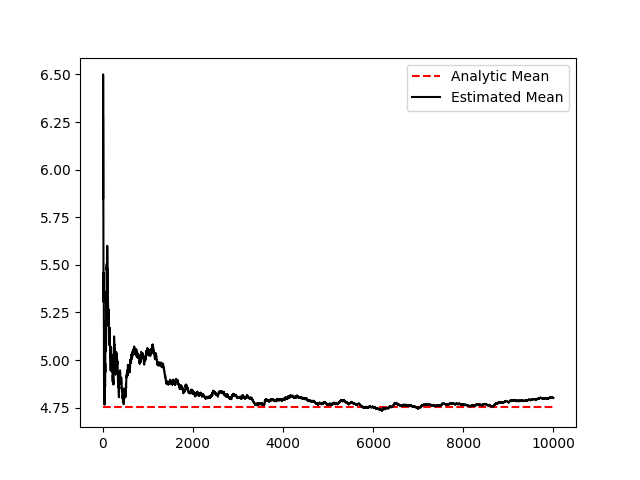

In [21]:
fig, ax = plt.subplots()

ax.plot([0,len(samples)], [est_mean]*2, '--r', label='Analytic Mean')
ax.plot(range(10,len(avgs)), avgs[10:], 'k', label='Estimated Mean')
ax.legend();
fig.show()

### Mixture Model - Mapping Heterogenous Data to the Simplex

Mixture models also provide a mapping of heterogenous data to a real vector: the posterior probability vector.

<IPython.core.display.Javascript object>


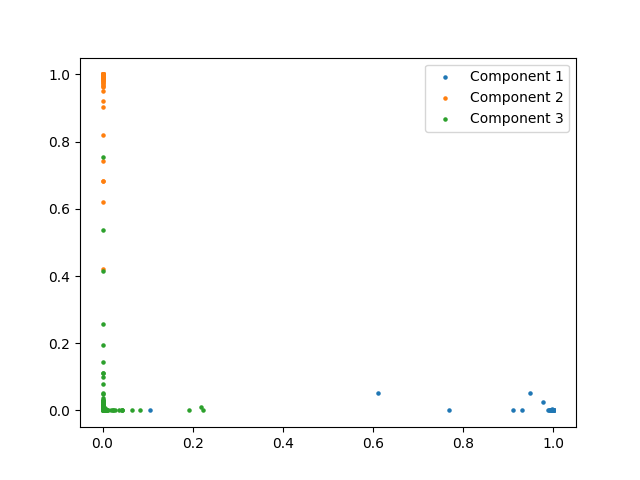

In [22]:
s1 = d1.sampler(seed=123).sample(size=100)
s2 = d2.sampler(seed=124).sample(size=100)
s3 = d3.sampler(seed=125).sample(size=100)

posterior1 = np.asarray([dist_est.posterior(u) for u in s1])
posterior2 = np.asarray([dist_est.posterior(u) for u in s2])
posterior3 = np.asarray([dist_est.posterior(u) for u in s3])

# Another way of doing this:
# posterior1 = dist_est.seq_posterior(dist_est.seq_encode(s1))

fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(posterior1[:,0], posterior1[:,1], s=5, label='Component 1')
ax.scatter(posterior2[:,0], posterior2[:,1], s=5, label='Component 2')
ax.scatter(posterior3[:,0], posterior3[:,1], s=5, label='Component 3')

ax.legend();
fig.show()

## Hierarchical Mixture Models

Hierarchical mixtures are mixtures of mixtures. They are useful for modeling a collection of mixtures that share the same components.

#### Hierarchical Mixture: Generative Process

The hierarchical mixture distribution is defined over a finite set of $K$ topic distributions $F_1, F_2, \dots, F_K$, a sequence length distribution $P(n)$, $M$ outer mixture weights $\boldsymbol{w}$, and $M$ inner mixture weights $\boldsymbol{\tau}_m$ of length $K$. Below is an outline of the generative process:

1. Draw $Z_i \sim \text{IntegerCategorical}\left(w_1, \dots, w_M\right)$
2. Draw $n_i \sim P(n)$
3. For $j = 1, 2, \dots, n_i$, draw $H_{ji} \mid Z_i = m \stackrel{iid}{\sim}$ IntegerCategorical($\tau_{m,1}, \dots, \tau_{m,K}$)
4. For $j = 1, 2, \dots, n_i$, draw $x_{ji} \mid H_{ji} = k \stackrel{iid}{\sim} F_{k}(x_{ji})$
5. Repeat steps 1–4 $N$ times

#### Hierarchical Mixture: Estimation

There are two ways to specify or estimate hierarchical mixture models in DMLearn.

The `HierarchicalMixtureDistribution` constructor takes three required arguments and an optional length argument:
- `topics`: a list of distributions
- `w`: a list of mixing weights for the outer mixture
- `taus`: a matrix of mixing weights for the inner mixture
- `len_dist`: a distribution for the length of each sequence (optional)

Alternatively, you can specify a hierarchical mixture as follows:

`mixtures = [SequenceDistribution(MixtureDistribution(topics, taus[i,:]), len_dist) for i in range(len(w))]`
`dist = MixtureDistribution(mixtures, w)`

This makes the hierarchical mixture distribution a mixture of sequences of mixtures.

---


In [22]:
d1 = GaussianDistribution(-5.0, 1.0)
d2 = GaussianDistribution( 0.0, 1.0)
d3 = GaussianDistribution( 5.0, 1.0)

# Each row of this matrix contains the mixing weights for a mixture over [d1,d2,d3]
taus = [[0.34, 0.33, 0.33], [0.8, 0.1 ,0.1], [0.1, 0.8 ,0.1], [0.1, 0.1 ,0.8]]

# This is the probability of each of the above rows
w = [0.4, 0.2, 0.2, 0.2]

model = HierarchicalMixtureDistribution([d1,d2,d3], w, taus, len_dist=CategoricalDistribution({5:1.0}))
data = model.sampler(seed=1).sample(1000)

The code above produces a hierarchical mixture model with:

- **3 Gaussian topics**
- **4 outer mixture weights**

The length distribution ensures that each sequence sampled has length 5.

The scatter plot below shows 20 samples, where each point is plotted as $(x_{ji}, i)$, with $j=1,2,3,4,5$ (the position in the sequence) and $i=1,2,\dots,20$ (the sample index).

In [23]:
fig, ax = plt.subplots()

for i,u in enumerate(data[:20]):
    ax.scatter(u, [i]*len(u))
fig.show()

<IPython.core.display.Javascript object>

The estimator `HierarchicalMixtureEstimator` takes two required arguments:

- `estimators`: a list of estimators for the topics (length $K$)
- `num_mixtures`: the number of topic mixtures or outer mixtures (length

In [24]:
est = HierarchicalMixtureEstimator([GaussianEstimator()]*3, 4)
model_v1 = optimize(data, est, max_its=200, rng=np.random.RandomState(1), print_iter=25)

Iteration 25: ln[p_mat(Data|Model)]=-1.302637e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=5.950863e+01
Iteration 50: ln[p_mat(Data|Model)]=-1.190994e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=1.016201e-01
Iteration 75: ln[p_mat(Data|Model)]=-1.190942e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=9.111872e-04
Iteration 100: ln[p_mat(Data|Model)]=-1.190942e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=1.189386e-05
Iteration 125: ln[p_mat(Data|Model)]=-1.190942e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=1.214345e-06
Iteration 150: ln[p_mat(Data|Model)]=-1.190942e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=2.042561e-07
Iteration 175: ln[p_mat(Data|Model)]=-1.190942e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=3.520290e-08
Iteration 200: ln[p_mat(Data|Model)]=-1.190942e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=6.077244e-09


In [25]:
print('\n'.join([str(u) for u in model_v1.topics]))
print('w: %s'%(str(model_v1.w)))
print('taus:')
print(model_v1.taus)

GaussianDistribution(-5.036824750623546, 0.9563690009862071, name=None, keys=None)
GaussianDistribution(-0.004531994989049176, 1.0929619567122069, name=None, keys=None)
GaussianDistribution(5.009270278893528, 0.9688609790066351, name=None, keys=None)
w: [0.2221587  0.39173692 0.20416792 0.18193647]
taus:
[[0.79858993 0.11156539 0.08984467]
 [0.32009744 0.30548923 0.37441334]
 [0.10133352 0.81312427 0.08554221]
 [0.08721596 0.11685828 0.79592576]]


### Estimation with Keys
Explicitly estimating a "mixture of sequence of mixtures" is another way to perform parameter estimation, although it is much slower. DMLearn provides a named components feature that is necessary for obtaining the same components for each mixture of mixtures.

Below, `est0` defines the inner mixture of three Gaussians. `est` is a `MixtureEstimator` with 4 components, each being a `SequenceEstimator` of `est0`. The setting `keys=(None, 'comps')` ensures that the components of the inner mixture are the same across each of the outer mixture's components. Sufficient statistics for these keyed components are aggregated during estimation, ensuring that our model

In [26]:
est0 = MixtureEstimator([GaussianEstimator()]*3, keys=(None, 'comps')) 
est = MixtureEstimator([SequenceEstimator(est0)]*4)

model_v2 = optimize(data, est, 500, rng=np.random.RandomState(1), print_iter=25)

Iteration 25: ln[p_mat(Data|Model)]=-1.430171e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=1.874334e-04
Iteration 50: ln[p_mat(Data|Model)]=-1.430171e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=3.126483e-04
Iteration 75: ln[p_mat(Data|Model)]=-1.430170e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=5.760842e-04
Iteration 100: ln[p_mat(Data|Model)]=-1.430167e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=1.234217e-03
Iteration 125: ln[p_mat(Data|Model)]=-1.430162e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=3.406531e-03
Iteration 150: ln[p_mat(Data|Model)]=-1.430143e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=1.569223e-02
Iteration 175: ln[p_mat(Data|Model)]=-1.429908e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=3.600103e-01
Iteration 200: ln[p_mat(Data|Model)]=-1.308720e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=5.503212e-01
Iteration 225: ln[p_mat(Data|Model)]=-1.191518e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]

Each mixture's components are the same as expected - that's because we gave them the same key.

In [27]:
print('Component 1:')
print('\n'.join([str(u) for u in model_v2.components[0].dist.components]))
print('Component 2:')
print('\n'.join([str(u) for u in model_v2.components[1].dist.components]))

Component 1:
GaussianDistribution(-0.00453200876092233, 1.092961936479222, name=None, keys=None)
GaussianDistribution(-5.036824751934192, 0.9563689964737705, name=None, keys=None)
GaussianDistribution(5.009270260396168, 0.9688610299468436, name=None, keys=None)
Component 2:
GaussianDistribution(-0.00453200876092233, 1.092961936479222, name=None, keys=None)
GaussianDistribution(-5.036824751934192, 0.9563689964737705, name=None, keys=None)
GaussianDistribution(5.009270260396168, 0.9688610299468436, name=None, keys=None)


The following steps will extract the remaining parameters. The results will closely match the estimation performed with the `HierarchicalEstimator` (we just may need to permute the order of the topics).

In [28]:
print('w:')
print(str(model_v2.w))
print('taus: ')
print('\n'.join([str(u.dist.w) for u in model_v2.components]))

w:
[0.18192737 0.22216098 0.3917417  0.20416995]
taus: 
[0.11685451 0.08721123 0.79593426]
[0.11156706 0.7985881  0.08984484]
[0.30548518 0.32009282 0.374422  ]
[0.81312227 0.10133506 0.08554267]


### Joint Mixture Model

The **joint mixture model** links the hidden states of two mixtures using a transition matrix. Although the model is fit with fully observed data, it is intended for applications where one variable is predicted from the posterior distribution of the other.

#### Generative Process

Consider a joint mixture model over two random variables $(X, Y)$, with $K$ component distributions $F_k$ for $X$ and $M$ component distributions $G_m$ for $Y$. The generative process for sampling $(X, Y)$ is as follows:

1. Draw $Z_i \sim \mathrm{IntegerCategorical}(\boldsymbol{w}_1)$  
   &nbsp;&nbsp;&nbsp;&nbsp;(*Choose a hidden state for $X$ with weights $\boldsymbol{w}_1$*)
2. Draw $H_i \mid Z_i = k \sim \mathrm{IntegerCategorical}(\boldsymbol{\tau}_{12}(k))$  
   &nbsp;&nbsp;&nbsp;&nbsp;(*Choose a hidden state for $Y$ based on $Z_i$ using transition matrix $\boldsymbol{\tau}_{12}$*)
3. Draw $X_i \mid Z_i = k \sim F_k(X_i)$  
   &nbsp;&nbsp;&nbsp;&nbsp;(*Sample $X_i$ from the $k$-th component*)
4. Draw $Y_i \mid H_i = m \sim G_m(Y_i)$  
   &nbsp;&nbsp;&nbsp;&nbsp;(*Sample $Y_i$ from the $m$-th component*)
5. Return sample $(X_i, Y_i)$ and repeat steps 1–4 $N$ times.

**Note:**  
In the above, we could swap steps (1) and (2):  
- First sample $H_i \sim \mathrm{IntegerCategorical}(\boldsymbol{w}_2)$  
- Then sample $Z_i \mid H_i = m \sim \boldsymbol{\tau}_{21}(m)$

This alternative ordering is mathematically equivalent, but may be useful depending on which variable you wish to condition on or predict.

In [30]:
rng = np.random.RandomState(1)

# Create the data
d11 = CompositeDistribution([CategoricalDistribution({'a': 1.0, 'b': 0.0, 'c': 0.0}), GaussianDistribution(mu=-2.0, sigma2=1.0)])
d12 = CompositeDistribution([CategoricalDistribution({'a': 0.0, 'b': 1.0, 'c': 0.0}), GaussianDistribution(mu= 0.0, sigma2=1.0)])
d13 = CompositeDistribution([CategoricalDistribution({'a': 0.0, 'b': 0.0, 'c': 1.0}), GaussianDistribution(mu= 2.0, sigma2=1.0)])

d21 = SequenceDistribution(GaussianDistribution(mu= 2.0, sigma2=1.0), PoissonDistribution(3.0))
d22 = SequenceDistribution(GaussianDistribution(mu= 0.0, sigma2=1.0), PoissonDistribution(3.0))
d23 = SequenceDistribution(GaussianDistribution(mu=-2.0, sigma2=1.0), PoissonDistribution(3.0))


taus12 = [[0.8, 0.1, 0.1], [0.1, 0.8, 0.1], [0.1, 0.1, 0.8]]
taus21 = [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
w1     = [0.6, 0.3, 0.1]
w2     = [0.7, 0.2, 0.1]

dist     = JointMixtureDistribution([d11, d12, d13], [d21, d22, d23], w1, w2, taus12, taus21)

sampler  = dist.sampler(seed=1)
data     = sampler.sample(10000)

train_data, valid_data = partition_data(data, [0.9, 0.1], rng)

In [31]:
# Make the estimator
est1 = CompositeEstimator([CategoricalEstimator(pseudo_count=1.0), GaussianEstimator()])
est2 = SequenceEstimator(GaussianEstimator(), PoissonEstimator())
est = JointMixtureEstimator([est1]*3, [est2]*3, pseudo_count=(0.001, 0.001, 0.001))


# Estimate parameters
_, mm = best_of(train_data, valid_data, est, 5, 300, 0.01, 1.0e-8, rng, print_iter=100)

Iteration 100. LL=-80984.303404, delta LL=5.616050e-06
Trial 1. VLL=-9162.337059
Iteration 100. LL=-80984.303441, delta LL=1.098150e-05
Trial 2. VLL=-9162.337059
Iteration 100. LL=-80984.303545, delta LL=2.626410e-05
Trial 3. VLL=-9162.337059
Iteration 100. LL=-80984.303393, delta LL=4.122820e-06
Trial 4. VLL=-9162.337059
Iteration 100. LL=-80984.303415, delta LL=7.262264e-06
Trial 5. VLL=-9162.337059


Lets take a look at the estimates for the component distributions. 

In [32]:
print('Component 1:')
print('\n'.join(map(str,mm.components1)))
print('\nComponent 2:')
print('\n'.join(map(str,mm.components2)))

Component 1:
CompositeDistribution(dists=[CategoricalDistribution({'a': 0.0012632722585794738, 'b': 0.9969854989313328, 'c': 0.0017512288100877903}, default_value=0.0, name=None, keys=None),GaussianDistribution(-0.00776694826322218, 1.0237821027468754, name=None, keys=None)], name=None, keys=None)
CompositeDistribution(dists=[CategoricalDistribution({'a': 0.9995822451781999, 'b': 0.00033936298630246874, 'c': 7.839183549748034e-05}, default_value=0.0, name=None, keys=None),GaussianDistribution(-2.0051926707702443, 1.001384934577576, name=None, keys=None)], name=None, keys=None)
CompositeDistribution(dists=[CategoricalDistribution({'a': 0.00046415849922148766, 'b': 0.0037672509506598848, 'c': 0.9957685905501186}, default_value=0.0, name=None, keys=None),GaussianDistribution(1.9969590393859715, 0.9598584961925001, name=None, keys=None)], name=None, keys=None)

Component 2:
SequenceDistribution(GaussianDistribution(-0.004904943333024344, 0.9634521482883979, name=None, keys=None), len_dist=

Lets also peak at the transition estimates for `tau12`.

In [33]:
print(str(mm.taus12))

[[0.80795678 0.09720116 0.09484206]
 [0.09564359 0.09559885 0.80875756]
 [0.09604721 0.80070166 0.10325113]]


Using the joint mixture is a bit cumbersome, but the transition matrix provides a very fast way of converting from observations from the first components to the second components.

Below `comp1` is just a mixture with components $F_k$ and weights $\boldsymbol{w}_1$, and `comp20` is a Mixture with components $G_m$ and weights $\boldsymbol{w}_2$.

In [34]:
comp1 = MixtureDistribution(mm.components1, mm.w1)
comp20 = MixtureDistribution(mm.components2, mm.w2)

print(train_data[0])

(('b', 1.4946853996379752), [-0.15588811084291587, -0.05153282194640127, 0.4458569915502529, -0.6620822149662811, 1.7274131140372457])


We first consider `old_posterior` obtained by taking the posterior over mixture of components $G_m$ and weights $\boldsymbol{w}_2$. From this we obtain $P(H | Y)$. We then compute `new_posterior` by instead converting the observation $X$ to $Y$ via the transition weights $\boldsymbol{\tau}_{12}$. To do this we compute compute the posterior 

$$P(H|X) = \sum_{k=1}^{K} P(X|Z=k)P(Z=k|H).$$

We then obtain the posterior of $P(H|Y, X)$ through the `MixtureDistribution` `comp2`, with component distributions $G_m$ as estimated before, but the weights are taken to be $P(H|X)$ as calculated above. 


In [35]:
old_posterior = comp20.posterior(train_data[0][1])

new_posterior = np.dot(comp1.posterior(train_data[0][0]), mm.taus12)
new_posterior /= new_posterior.sum()
comp2 = MixtureDistribution(mm.components2, new_posterior)


print('P(H|X, Y) = ' + str(comp2.posterior(train_data[0][1])))
print('P(H|Y)    = ' + str(old_posterior))

P(H|X, Y) = [9.99914370e-01 4.48108839e-07 8.51814067e-05]
P(H|Y)    = [9.98775214e-01 1.93336787e-06 1.22285236e-03]


## Heterogeneous Mixture Distribution

DMLearn also allows for the specification of **heterogeneous mixture models**.

---

**Recall: Mixture Model**

Given a finite set of likelihood functions $\ell_1(x; \theta_1), \dots, \ell_K(x; \theta_K)$ and weights $w_1, \dots, w_K$ such that $w_k \geq 0$ and $\sum_{k=1}^{K} w_k = 1$, the mixture distribution has likelihood

$$
\ell(x; \boldsymbol{\theta}) = \sum_{k=1}^{K} w_k\, \ell_k(x; \theta_k)
$$

In the standard mixture model, each of the component distributions $\ell_j(x; \theta_j)$ are assumed to be of the same type (e.g., all Gaussians).

The `HeterogeneousMixtureDistribution` only requires that the component distributions $\ell_j(x; \theta_j)$ have the **same support** (e.g., all defined on the positive real line), but they can be of different types.

---

### Example 1: Continuous Heterogeneous Mixture

The first example is a `HeterogeneousMixtureDistribution` of two `ExponentialDistribution`s and one `LogGaussianDistribution`. All have support on the positive real numbers.

The estimator `est` requires that you pass in estimator objects for each distribution, for the specified number of components.


In [36]:
d0 = ExponentialDistribution(beta=5.00)
d1 = ExponentialDistribution(beta=10.0)
d2 = LogGaussianDistribution(mu=0.5, sigma2=1.0)

omodel = HeterogeneousMixtureDistribution([d0, d1, d2], w=[0.1, 0.3, 0.6])
data = omodel.sampler(1).sample(10000)

e0 = [ExponentialEstimator()]*2
e1 = [LogGaussianEstimator()]
est = HeterogeneousMixtureEstimator(e0+e1)

emodel = optimize(data, est, init_p=1.0, rng=np.random.RandomState(1), max_its=1000, print_iter=100)

Iteration 100: ln[p_mat(Data|Model)]=-2.547927e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=3.973776e-03
Iteration 200: ln[p_mat(Data|Model)]=-2.547911e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=4.841382e-04
Iteration 300: ln[p_mat(Data|Model)]=-2.547908e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=6.413315e-05
Iteration 400: ln[p_mat(Data|Model)]=-2.547908e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=1.021658e-05
Iteration 500: ln[p_mat(Data|Model)]=-2.547908e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=3.015270e-06
Iteration 600: ln[p_mat(Data|Model)]=-2.547908e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=1.924411e-06
Iteration 700: ln[p_mat(Data|Model)]=-2.547908e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=1.648765e-06
Iteration 800: ln[p_mat(Data|Model)]=-2.547908e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=1.491244e-06
Iteration 900: ln[p_mat(Data|Model)]=-2.547908e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevMode

In [37]:
for i, comp in enumerate(emodel.components):
    print('Component %i: %s' % (i, repr(comp)))

Component 0: ExponentialDistribution(np.float64(5.903815359794076), name=None, keys=None)
Component 1: ExponentialDistribution(np.float64(10.7314924258924), name=None, keys=None)
Component 2: LogGaussianDistribution(np.float64(0.4581787026377451), np.float64(0.9416944000228917), name=None, keys=None)


### Example 2: Discrete Heterogeneous Mixture

Now let's look at a discrete example. Here, we use a `HeterogeneousMixtureDistribution` of a `PoissonDistribution` and a `SpikeAndSlabDistribution`.

In [56]:
N = 10000
d1 = SpikeAndSlabDistribution(k=7, min_val=0, num_vals=10, p=0.95)
d2 = PoissonDistribution(lam=1.0)

d = HeterogeneousMixtureDistribution([d1, d2], np.ones(2)/2)
data = d.sampler(1).sample(N)

We'll plot the data below to see the two spikes placed on `k=2` and `k=7`.

In [57]:
fig,ax = plt.subplots()
ax.hist(data, bins=range(0,12))
fig.show()

<IPython.core.display.Javascript object>

We specify a list of the heterogenous estimator types as before, then make a call to `optimize`. 

In [58]:
est0 = [SpikeAndSlabEstimator()]
est1 = [PoissonEstimator()]
est = HeterogeneousMixtureEstimator(est0+est1)

emodel = optimize(data, est, init_p=1.0, rng=np.random.RandomState(1), max_its=1000, print_iter=100)

Iteration 33: ln[p_mat(Data|Model)]=-1.453655e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=4.747562e-10


In [59]:
for i, comp in enumerate(emodel.components):
    print('Component %i: %s' % (i, repr(comp)))

Component 0: SpikeAndSlabDistribution(p=np.float64(0.9437934265454095), min_val=0, num_vals=10,k=np.int64(7), name=None, keys=None)
Component 1: PoissonDistribution(1.0011442333411156, name=None, keys=None)
